In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Runge-Kutta 4

## Implementation

In [2]:
def solve_pendulum(inic, g = 9.81, L = 5, start_time = 0, end_time = 10, dt = 0.001, saa = True):
    def thetadot(omega):
        return omega

    def omegadot(theta):
        if saa:
            return -(g/L) * theta
        else:
            return -(g/L) * np.sin(theta)

    def dot(theta, omega):
        return np.array([thetadot(omega), omegadot(theta)])
    
    phase = np.array(inic) # theta, omega
    phases = []
    
    t = np.arange(start_time, end_time, dt)
    
    for _ in t:
        phases.append(phase)

        K1 = dt * dot(*phase) # Euler iteration, returns (theta_next, omega_next)
        
        # K2 = dt * dot(phase[0] + K1[0]/2, phase[1] + K1[1]/2)
        # K3 = dt * dot(phase[0] + K2[0]/2, phase[1] + K2[1]/2)
        # K4 = dt * dot(phase[0] + K3[0], phase[1] + K3[1])

        K2 = dt * dot(*(phase + K1/2))
        K3 = dt * dot(*(phase + K2/2))
        K4 = dt * dot(*(phase + K3))

        phase = phase + K1/6 + K2/3 + K3/3 + K4/6
        
    theta = [elem[0] for elem in phases]
    omega = [elem[1] for elem in phases]
    
    return (t, theta, omega)

## Results

In [3]:
def plot_pendulum(inic, saa_switch):
    t, theta, omega = solve_pendulum(inic, saa = saa_switch)

    plt.figure(figsize=(15, 5))

    plotting_data = [
        {
            "varname": r"Angular Displacement $\theta$", 
            "data": theta, 
            "y_units": "Rad"
        },
        {
            "varname": r"Angular Velocity $\omega$", 
            "data": omega, 
            "y_units": "Rad/s"
        },
    ]

    for i in range(len(plotting_data)):
        plt.subplot(1, len(plotting_data), i + 1) # rows, cols, index

        obj = plotting_data[i]
        plt.plot(t, obj["data"])

        plt.title(fr"""{obj["varname"]}
{["without", "with"][saa_switch]} SAA
with $\theta(0) = {np.round(np.degrees(inic))[0]}^\circ$, $\omega(0) = {np.round(np.degrees(inic))[1]}$ deg/s""")

        plt.xlabel("Time (s)")
        plt.ylabel(obj["y_units"])

    plt.show()

### 1. With $\sin \theta \approx \theta$

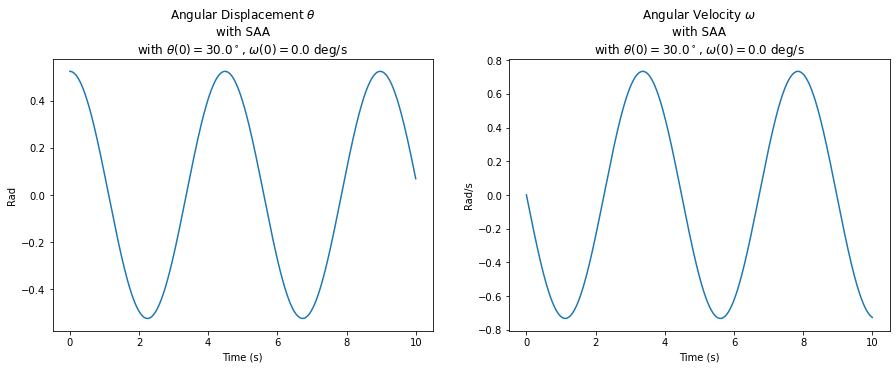

In [4]:
%matplotlib inline

inic = [np.radians(30), np.radians(0)] # Initial conditions [theta (in Rad), omega (in Rad)]
saa_switch = True

plot_pendulum(inic, saa_switch)

### 2. Without $\sin \theta \approx \theta$

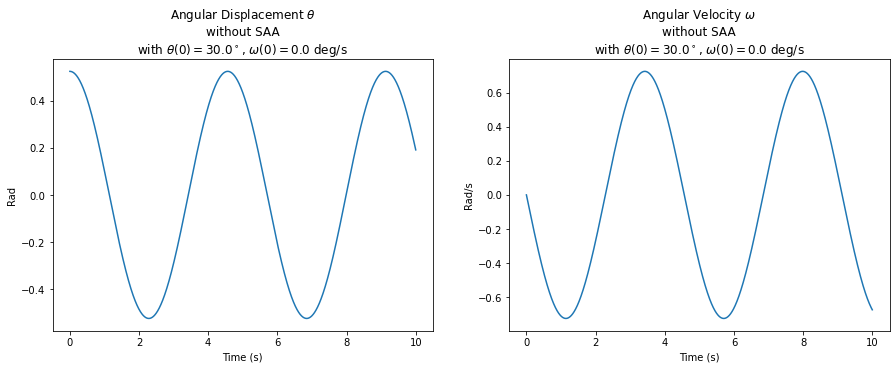

In [5]:
%matplotlib inline

inic = [np.radians(30), np.radians(0)] # Initial conditions [theta (in Rad), omega (in Rad)]
saa_switch = False

plot_pendulum(inic, saa_switch)

### 3. Comparing with and without $\sin \theta \approx \theta$ with changing initial conditions

In [6]:
def compare_SAA(inic):
    plt.figure(figsize=(15, 5))
    
    plotting_data = [
        {
            "varname": r"Angular Displacement $\theta$", 
            "solutions_index": 1, 
            "y_units": "Rad"
        },
        {
            "varname": r"Angular Velocity $\omega$", 
            "solutions_index": 2, 
            "y_units": "Rad/s"
        },
    ]
    
    label_switch = lambda saa_switch: ["without", "with"][saa_switch]

    for i in range(len(plotting_data)):
        plt.subplot(1, len(plotting_data), i + 1) # rows, cols, index

        obj = plotting_data[i]
        for saa_switch in [True, False]:
            solutions = solve_pendulum(inic, saa = saa_switch) # t, theta, omega

            plt.plot(solutions[0], solutions[obj["solutions_index"]], label=f"{label_switch(saa_switch)} SAA")

        plt.title(fr"""{obj["varname"]}
with and without SAA
with $\theta(0) = {np.round(np.degrees(inic))[0]}^\circ$, $\omega(0) = {np.round(np.degrees(inic))[1]}$ deg/s""")

        plt.xlabel("Time (s)")
        plt.ylabel(obj["y_units"])
        plt.legend()

    plt.show()

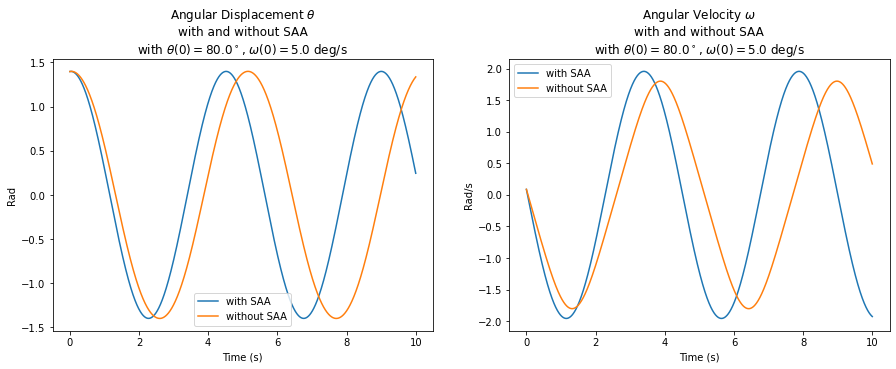

In [7]:
%matplotlib inline

inic = [np.radians(80), np.radians(5)] # Initial conditions [theta (in Rad), omega (in Rad)]

compare_SAA(inic)

# Animation

In [8]:
from matplotlib.animation import FuncAnimation

def animate_pendulum(inic, saa_switch, L = 0.3, frames = 1000, interval = 1, compare = False):
    
    t, theta, omega = solve_pendulum(inic, L = L, saa = saa_switch)
    
    fig = plt.gcf()
    fig.set_size_inches(10, 10)

    origin = np.array([1/2, 1/2])
    
    ax = plt.gca()
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.set(ylim=(0, 1))
    ax.set(xlim=(0, 1))
    
    if not compare:
        plot_title = f'Simple Pendulum solved using Runge-Kutta 4 {["without", "with"][saa_switch]} SAA'
    else:
        plot_title = f"""Simple Pendulums solved using Runge-Kutta 4
blue: without SAA
green: with SAA"""

    plt.title(plot_title)
    plt.axis('off')

    def get_line_coords(start, end):
        x = [coord[0] for coord in [start, end]]
        y = [coord[1] for coord in [start, end]]

        return x, y

    def bob_position(length, angle):
        return origin + np.array([length * np.sin(angle), -length * np.cos(angle)])

    line = ax.plot([], [], color=["black", "brown"][saa_switch])[0]
    bob = plt.Circle((0, 0), 0.02, color=["blue", "green"][saa_switch])

    patches = [line, bob]

    step = len(theta) // frames
    theta_animate = theta[::step]

    def init():
        line = patches[0]
        bob = patches[1]

        line.set_data(*get_line_coords(origin, bob_position(L, theta[0])))

        bob.center = bob_position(L, theta[0])
        ax.add_patch(bob)

        return patches

    def animate(frame):
        line = patches[0]
        bob = patches[1]

        angle = theta_animate[frame]

        line.set_data(*get_line_coords(origin, bob_position(L, angle)))

        bob.center = bob_position(L, angle)

        return patches

    return FuncAnimation(fig, animate, init_func = init, interval = interval, frames = frames, blit=True)

### 1. With $\sin \theta \approx \theta$

<IPython.core.display.Javascript object>


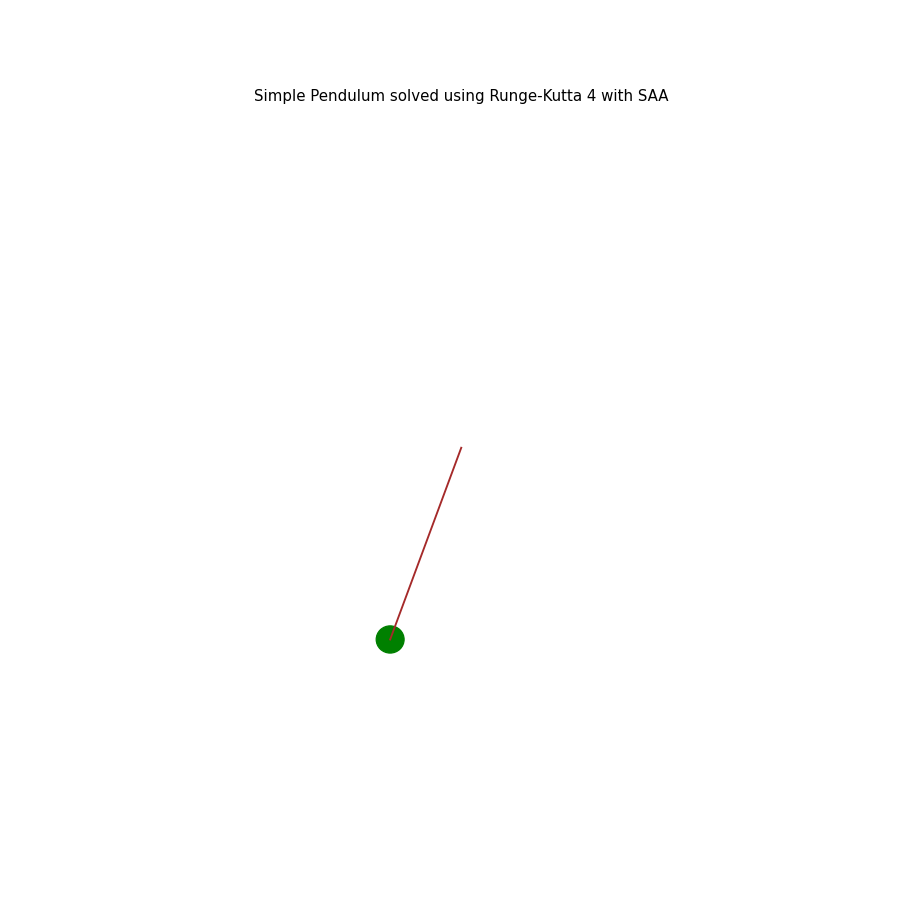

In [16]:
# Displaying animation
%matplotlib notebook

inic = [np.radians(30), np.radians(0)] # Initial conditions [theta (in Rad), omega (in Rad)]

anim = animate_pendulum(inic, True)

In [17]:
# Saving animation

anim.save("simple_pendulum_RK4_with_SAA.mp4", fps=30)

### 2. Without $\sin \theta \approx \theta$

<IPython.core.display.Javascript object>


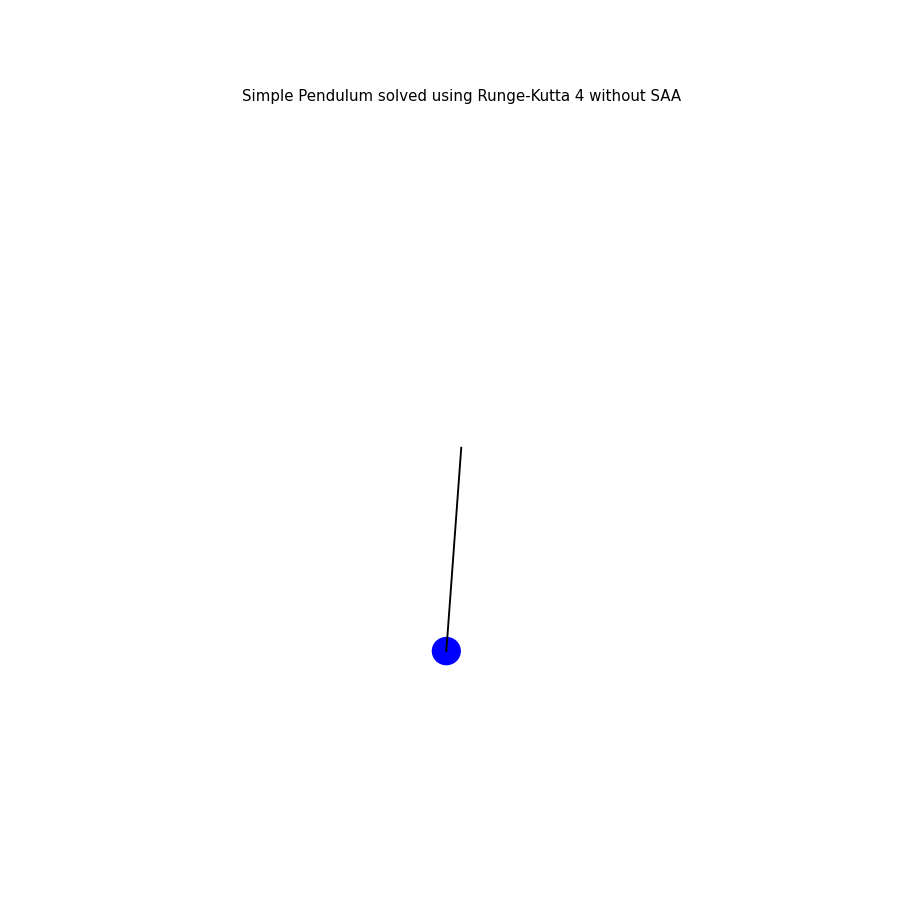

In [53]:
# Displaying animation
%matplotlib notebook

inic = [np.radians(30), np.radians(0)] # Initial conditions [theta (in Rad), omega (in Rad)]

anim = animate_pendulum(inic, False)

In [ ]:
# Saving animation

# anim.save("simple_pendulum_RK4_without_SAA.gif", fps=30)

### 3. Comparing with and without $\sin \theta \approx \theta$ with changing initial conditions

<IPython.core.display.Javascript object>


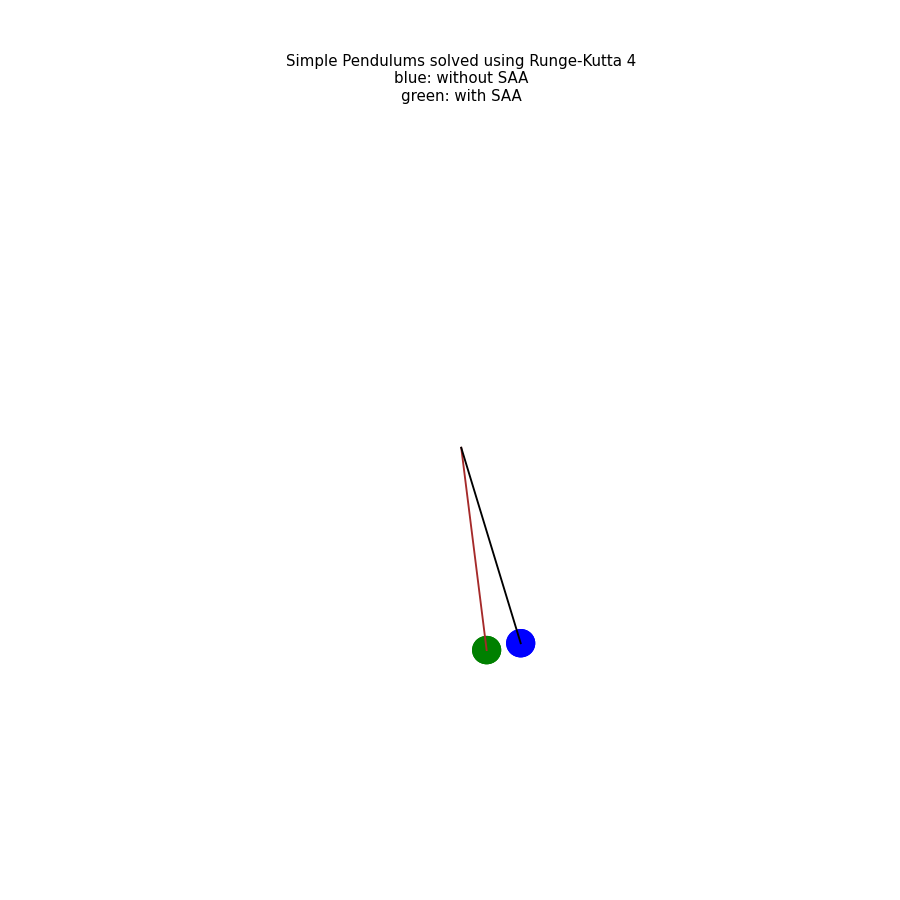

In [58]:
# Displaying animation
%matplotlib notebook

inic = [np.radians(30), np.radians(0)] # Initial conditions [theta (in Rad), omega (in Rad)]

anim_linear = animate_pendulum(inic, True, compare = True)
anim_nonlinear = animate_pendulum(inic, False, compare = True)

In [ ]:
# Saving animation

# "simple_pendulum_RK4_with_and_without_SAA.gif"

# need to save manually by screen capturing?